1. 데이터 준비 및 전처리

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import torch
from torch.utils.data import DataLoader, TensorDataset

# 데이터 로드
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# 데이터 확인 (상위 5개 행 출력)
print(train_df.head())

# X_train: 이미지 데이터 (픽셀 값)
# 첫 번째 열 (ID)와 두 번째 열 (label)을 제외한 나머지 1024개의 값을 가져옴
X_train = train_df.iloc[:, 2:].values  # 첫 번째 열 ID, 두 번째 열 label 제외
y_train = train_df['label'].values  # 레이블

# X_test: 테스트 이미지 데이터
X_test = test_df.iloc[:, 1:].values  # 첫 번째 열 ID 제외하고 나머지 1024개 픽셀 값

# X_train 크기 확인
print("X_train shape:", X_train.shape)

# 1D 배열을 32x32 이미지 형태로 변환
if X_train.shape[1] == 1024:  # 1024개의 픽셀 값을 가져야 함
    X_train = X_train.reshape(-1, 1, 32, 32)  # (N, 1, 32, 32)로 변환 (N은 샘플 수)
    X_test = X_test.reshape(-1, 1, 32, 32)
else:
    print("X_train의 형상 문제: 각 이미지가 1024개의 픽셀 값을 가져야 합니다.")

# 레이블 인코딩 (문자열 -> 정수)
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)

# PyTorch 텐서로 변환
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)

X_test = torch.tensor(X_test, dtype=torch.float32)

# 데이터 확인
print("X_train shape:", X_train.shape)  # (샘플 수, 1, 32, 32)
print("y_train shape:", y_train.shape)


          ID     label    0    1    2    3    4    5    6    7  ...  1014  \
0  TRAIN_000  building  251  196   51   63   68   78  189   34  ...    85   
1  TRAIN_001  building  247  184  203  237  255  255  193  255  ...   242   
2  TRAIN_002  building  217  223  232  231  239  212  109  115  ...    96   
3  TRAIN_003       cat  133  149  153  138   68  157  159  166  ...   245   
4  TRAIN_004  building  240  213  187  159  112  134  239  233  ...   148   

   1015  1016  1017  1018  1019  1020  1021  1022  1023  
0   195    63    30    73    65    63   201   251   248  
1   239   241   242   242   241   241   241   240   238  
2    90   103   166   191   163   190   190   206   231  
3   241   247   255   250   190   186   244   254   201  
4    59   163   133    92   196   221   194   182   251  

[5 rows x 1026 columns]
X_train shape: (769, 1024)
X_train shape: torch.Size([769, 1, 32, 32])
y_train shape: torch.Size([769])


2. 모델 설계

In [ ]:
import torch.nn as nn
import torch.optim as optim

class IconClassifier(nn.Module):
    def __init__(self):
        super(IconClassifier, self).__init__()

        # Convolutional Layer 1: 1 채널 입력, 32 출력
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)  # (1, 32, 32) -> (32, 32, 32)
        self.pool = nn.MaxPool2d(2, 2)  # (32, 32) -> (32, 16)

        # Convolutional Layer 2: 32 채널 입력, 64 출력
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # (32, 16, 16) -> (64, 16, 16)

        # Fully Connected Layer: 64채널에서 10개 클래스 출력 (10개 아이콘 종류)
        self.fc1 = nn.Linear(64 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, 10)  # 10 클래스

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))  # Convolutional Layer 1
        x = self.pool(torch.relu(self.conv2(x)))  # Convolutional Layer 2
        x = x.view(-1, 64 * 16 * 16)  # Flatten
        x = torch.relu(self.fc1(x))  # Fully Connected Layer 1
        x = self.fc2(x)  # Fully Connected Layer 2 (클래스 예측)
        return x

# 모델 초기화
model = IconClassifier()


In [ ]:
# 데이터셋 준비
train_dataset = TensorDataset(X_train, y_train)

# DataLoader 준비
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


4. 모델 학습

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# 예시 모델 정의 (간단한 CNN)
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)  # 출력 크기 수정
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, 2)  # (32x32 -> 16x16)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, 2)  # (16x16 -> 8x8)
        x = x.view(x.size(0), -1)  # 배치 크기를 제외하고 나머지 차원 펼침
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# DataLoader 준비 (배치 크기 설정)
batch_size = 64
train_data = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

# 모델, 손실 함수, 옵티마이저 정의
model = SimpleCNN(num_classes=10)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 모델 학습 함수
def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()  # 모델을 학습 모드로 설정
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in train_loader:
            # 입력, 레이블을 디바이스로 보내기 (CPU/GPU)
            inputs, labels = inputs.to(device), labels.to(device)

            # 순전파
            outputs = model(inputs)

            # 손실 계산
            loss = criterion(outputs, labels)

            # 역전파
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # 통계 계산
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # 에폭마다 출력
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {100 * correct / total:.2f}%")

# 학습을 위한 디바이스 설정 (GPU 사용 여부)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 모델 학습
train_model(model, train_loader, criterion, optimizer, num_epochs=10)


Epoch [1/10], Loss: 14.7120, Accuracy: 14.69%
Epoch [2/10], Loss: 2.0540, Accuracy: 33.55%
Epoch [3/10], Loss: 1.1279, Accuracy: 64.24%
Epoch [4/10], Loss: 1.1066, Accuracy: 68.66%
Epoch [5/10], Loss: 0.5539, Accuracy: 80.75%
Epoch [6/10], Loss: 0.3583, Accuracy: 88.95%
Epoch [7/10], Loss: 0.2645, Accuracy: 91.29%
Epoch [8/10], Loss: 0.1440, Accuracy: 95.19%
Epoch [9/10], Loss: 0.0715, Accuracy: 98.57%
Epoch [10/10], Loss: 0.0515, Accuracy: 98.83%


In [ ]:
import pandas as pd

# test.csv 파일을 읽어 ID 정보를 추출
test_data = pd.read_csv('test.csv')

# X_test_ids: test.csv에서 'ID' 컬럼만 추출
X_test_ids = test_data['ID'].values

# 모델을 평가 모드로 설정
model.eval()

# X_test가 CPU에 있다면 GPU로 이동 (이 부분을 추가)
X_test = X_test.to(device)

# 예측 수행
with torch.no_grad():  # 기울기 계산 안 함
    outputs = model(X_test)
    _, predicted = torch.max(outputs, 1)  # 예측된 레이블 (정수형)

# 예측된 레이블 저장
predicted_labels = predicted.cpu().numpy()  # CPU로 이동 후 numpy 배열로 변환

# 예측 결과를 CSV 파일로 저장
result = pd.DataFrame({'ID': X_test_ids, 'Predicted Label': predicted_labels})
result.to_csv('predictions.csv', index=False)


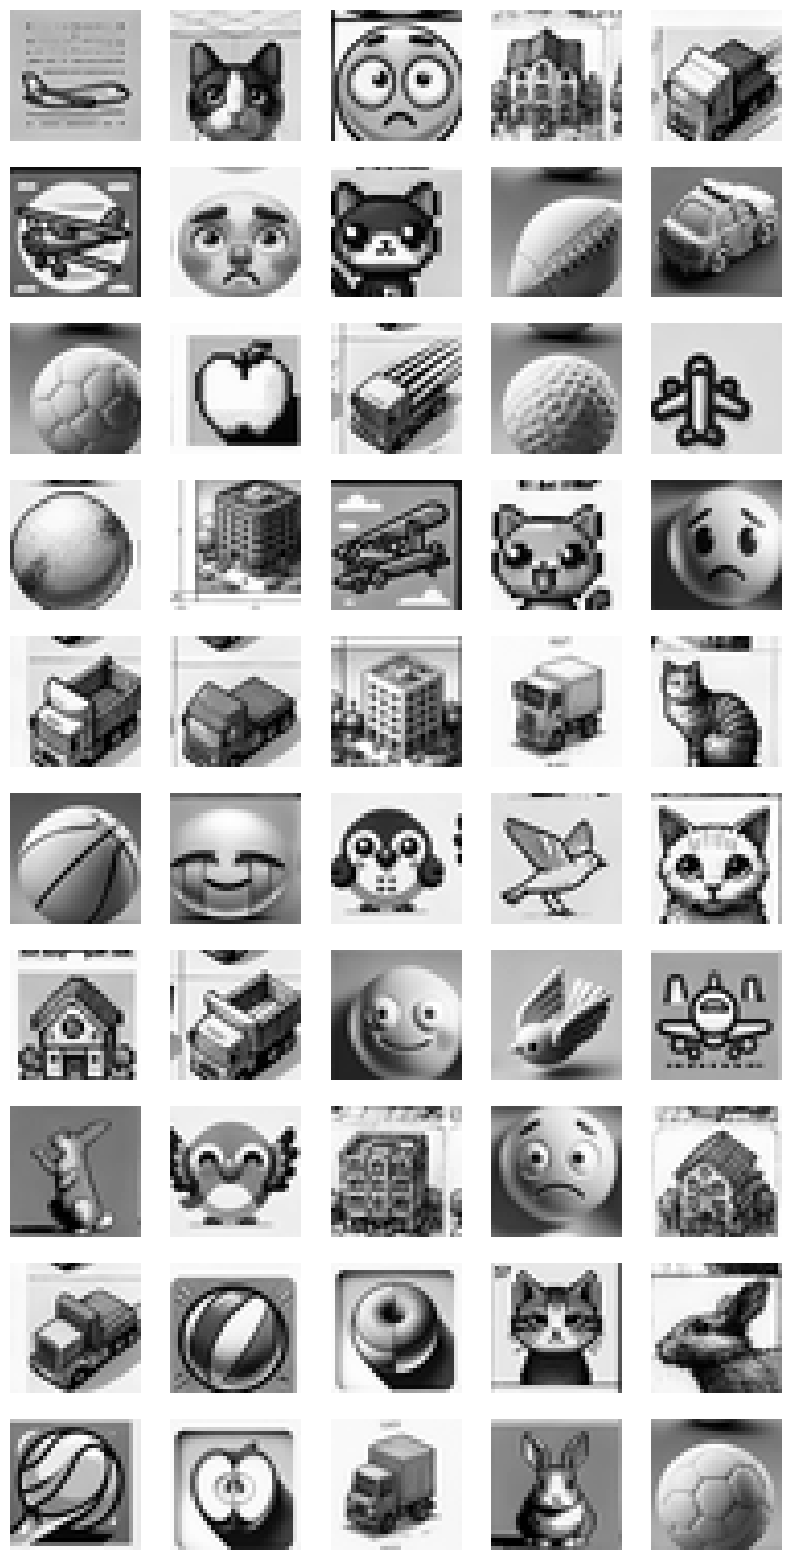

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# CSV 파일 로드 (파일명이 'test.csv'라고 가정)
test_data = pd.read_csv('test.csv')

# 이미지 데이터가 몇 번째 컬럼부터 시작하는지 확인 (ID 컬럼이 있다면 두 번째부터)
image_data = test_data.iloc[:, 1:].values  # ID를 제외한 나머지 컬럼을 가져옴

# 이미지 데이터가 몇 개의 픽셀을 가지고 있는지 확인
num_pixels = image_data.shape[1]
image_size = int(np.sqrt(num_pixels))  # 가정: 정사각형 이미지 (예: 32x32)

# 여러 개의 이미지를 출력하는 함수
def visualize_test_images(images, num_samples=50):
    plt.figure(figsize=(10,20))  # 전체 그래프 크기 조정
    for i in range(num_samples):
        plt.subplot(10,5, i + 1)  # 5행 10열로 배치
        plt.imshow(images[i].reshape(image_size, image_size), cmap='gray')
        plt.axis('off')  # 축 제거
    plt.show()

# 이미지 데이터 변환 (float 형식으로 변경)
image_data = image_data.astype(np.float32)

# 50개의 이미지 출력
visualize_test_images(image_data, num_samples=50)
